<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Attempt-to-slow-down-the-greedy-blighter" data-toc-modified-id="Attempt-to-slow-down-the-greedy-blighter-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Attempt to slow down the greedy blighter</a></span></li></ul></div>

# Naive attempt

This method just shifts the likelyhood that a certain variant is picked to be proportional to that variants running sample proportion.  This ends up over-filling poor performing variants.

In [659]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.special import gamma
import matplotlib.pyplot as plt
import seaborn as sns
from numba import jit

# Save default color list for use later
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [104]:
proportions = [0.1,0.2,0.15,0.3,0.05]

         
# for person in range(10_000):
#     # Place person into one of the variants at random
#     variant = np.random.choice(range(len(proportions)),p=means[person])
#     results[variant].update({person:np.random.binomial(1,proportions[variant])})
#     if person > 1000:
#         means_temp = np.array([np.mean(list(results[i].values())) for i in results.keys()])
#         means.append(means_temp/means_temp.sum())
#     else:
#         means.append(means_init)

In [996]:
class simulation():

    def __init__(self, iterations = 10_000, sim_type='random', proportions = [0.1,0.2,0.15,0.3,0.05], epsilon = None):
        self.sim_type = sim_type
        self.proportions = proportions
        self.epsilon = epsilon
        self.iterations = iterations

        self.n_bandits = len(self.proportions)
        self.variants = np.arange(self.n_bandits)

        self.results = np.empty((self.iterations,8))
        self.results[:] = np.NaN
        self.count_per_bandit = np.zeros(n_bandits)
        self.mean_per_bandit  = np.zeros(n_bandits)
        self.stddev_per_bandit = np.zeros(n_bandits)
        
        # For Thompson Sampling
        
        # Successes - \alpha in the literature
        self.successes = np.ones(n_bandits)
        # Failures - \beta in the literature
        self.failures = np.ones(n_bandits)


    def _choose(self, person):
        '''Choose a variant in one of a number of ways defined by sim_type'''
        if self.sim_type=='random':
            return np.random.choice(self.variants)
        elif (self.sim_type=='egreedy') | (self.sim_type=='slow_greedy'):
            # Ramp epsilon down from 1 if early in the simulation for slow_greedy 
            if self.sim_type=='slow_greedy':
                epsilon = (np.exp(-person/1000)+self.epsilon) # Note this will be above 1 at early time, but this doesn't matter to us
            else:
                epsilon = self.epsilon
                
            # 5% random sample, otherwise pick best according to current means
            if np.random.random() < epsilon:
                return np.random.choice(self.variants)
            else:
                return np.argmax(self.mean_per_bandit)
            
        elif self.sim_type=='Thompson':
            return np.argmax(self.mean_per_bandit)

    def run_simulation(self):
        print('Running simulation...',end='')
        for person in range(self.iterations):
            # Place person into one of the variants at random
            variant = self._choose(person) 
            outcome = np.random.binomial(1,self.proportions[variant])

            # Recalculate means
            self.mean_per_bandit[variant] = self.mean_per_bandit[variant]*(1+self.count_per_bandit[variant])+outcome
            self.count_per_bandit[variant] += 1
            self.mean_per_bandit[variant] /= (1+self.count_per_bandit[variant])
            self.stddev_per_bandit[variant] = np.sqrt(self.mean_per_bandit[variant]*(1-self.mean_per_bandit[variant])/self.count_per_bandit[variant])

            # Update successes/failures
            self.successes[variant] += outcome
            self.failures[variant] += 1-outcome
            
            # Get probabilities
            if self.sim_type == 'Thompson':
                for v in self.variants:
                    self.mean_per_bandit[v] = np.random.beta(self.successes[v], self.failures[v])
            else:
                self.count_per_bandit[variant] = self.successes[variant]+self.failures[variant]
                self.mean_per_bandit[variant] = self.successes[variant]/(self.count_per_bandit[variant])
                self.stddev_per_bandit[variant] = np.sqrt(self.mean_per_bandit[variant]*(1-self.mean_per_bandit[variant])/self.count_per_bandit[variant])


            self.results[person] = [person, variant, outcome, self.count_per_bandit[variant], self.mean_per_bandit[variant], self.stddev_per_bandit[variant], self.successes[variant], self.failures[variant]]
        
        print('Done')
        return self.results
    
    
    def plot_simulation_output(self):
        print('Plotting...',end='')

        df = pd.DataFrame(self.results, columns=['Iteration','Variant','Outcome','Variant_Count','Variant_Mean','Variant_Stddev','Successes','Failures'])
        df.Variant = df.Variant.astype('category')
        
        fig,ax = plt.subplots(4,1,figsize=(15,15), gridspec_kw={'height_ratios': [1,3,4,3]})
        #plt.grid(axis='x')
        
        #ax.yticks(range(len(proportions)))
        # Axis formatting
        ax[0].set_ylabel('Variant')
        ax[0].set_title('Variant choice through time')
        ax[0].set_yticks(variants)
        lims = min(variants)-1,max(variants)+1
        ax[0].set_ylim(lims)

        ax[1].set_title('Variant ratios through time')
        ax[1].set_ylabel('Ratio of variants')


        ax[2].set_title('Variant means through time')
        ax[2].set_ylabel('Estimated Mean')
        ax[2].set_yticks(np.arange(0,1,0.2))

        ax[3].set_ylabel('Capture')
        ax[3].set_ylim([0,1.2])
        
        for a in ax[:-1]:
            a.set_xticklabels([])
        ax[-1].set_xlabel('Iteration')

        for a in ax:
            a.set_xlim([-self.iterations/20,self.iterations*1.1])
            
        groups = df.groupby("Variant")
        # Scatter of variant choices
        for name, group in groups:
            ax[0].plot(group["Iteration"], group["Variant"], marker="|", linestyle="", label=name)
            # Swarm plot takes a while to plot
            #sns.swarmplot(group["Iteration"], group["Variant"], ax = ax[0])

        # Stacked area of variant choice proportions
        stacks = df.pivot(index='Iteration',columns='Variant',values='Variant_Count').ffill().fillna(0)
        # Normalise by row
        stacks = stacks.apply(lambda x: x/sum(x), axis=1)
        ax[1].stackplot(stacks.index,  stacks.values.T, alpha = 0.8);
        # Annotate final sample ratios
        y_loc = 0
        for i, j in enumerate(stacks.values[-1]):
            y_loc += j/2
            ax[1].annotate('{:0.2f}'.format(j),(self.iterations*1.005,y_loc), color=colors[i], va='center')
            y_loc += j/2

        # Lineplot of estimates of variant means 
        for i in variants:
            data = df[df.Variant==i]
            if self.sim_type=='Thompson':
                line, = ax[2].plot('Iteration', 'Variant_Mean',data=data, marker='.', ms=2, lw=0)
            else:
                line, = ax[2].plot('Iteration', 'Variant_Mean',data=data)
            # Annotate final means
            x,y = self.iterations*1.005,line.get_ydata()[-1]

            ax[2].fill_between(data.Iteration
                            , data.Successes/(data.Successes+data.Failures) - 2*data.Variant_Stddev
                            , data.Successes/(data.Successes+data.Failures) + 2*data.Variant_Stddev
                            , color=colors[i], alpha=0.1)
            
            ax[2].annotate('{:0.2f} (c: {:0.2f})'.format(y, proportions[i]),(x,y), color=colors[i])

        ax[2].set_ylim([0,df.Variant_Mean.max()*1.2]);
        
        # Capture (%age of max expectation) plot
        exp_best = df.Iteration*max(proportions)
        current_score = df.Outcome.cumsum()
        capture = current_score/exp_best
        regret = (exp_best - current_score)/exp_best
        line, = ax[3].plot(capture, c='k', ls='--')
        x,y = line.get_xdata()[-1],line.get_ydata()[-1]
        ax[3].annotate('{:0.2f}'.format(y),(x+iterations/150,y), va='center')
        print('Done')

    

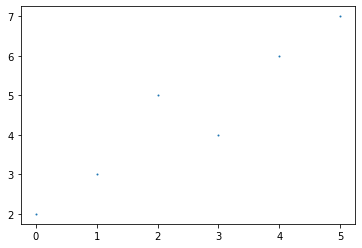

In [983]:
plt.plot([0,1,2,3,4,5],[2,3,5,4,6,7], marker='.',ms=2, lw=0 );

Running simulation...Done
Plotting...Done


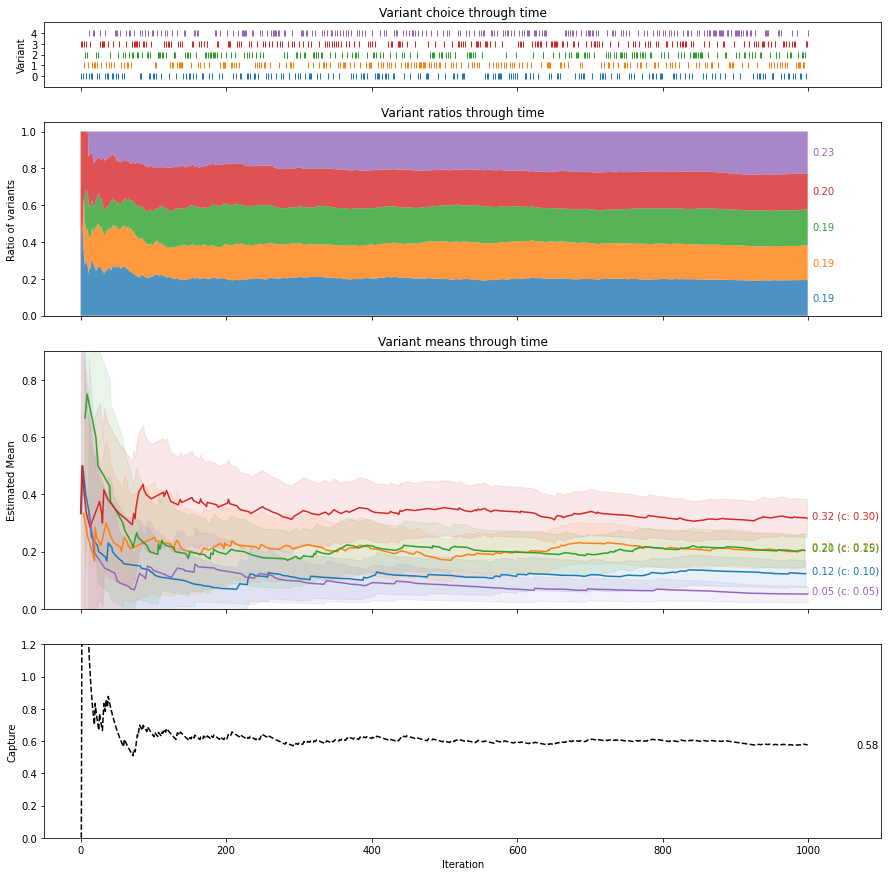

In [1003]:
random = simulation(iterations=1_000)
random.run_simulation()
random.plot_simulation_output()


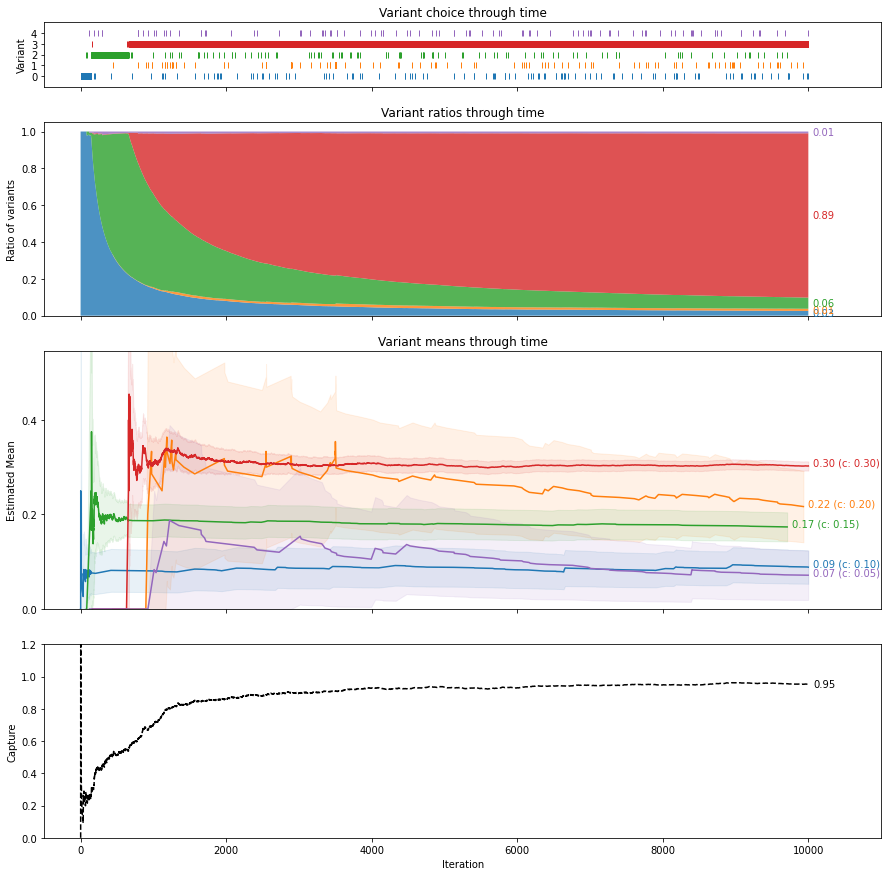

In [673]:
egreedy = simulation(sim_type='egreedy', epsilon = 0.05)
egreedy.run_simulation()
egreedy.plot_simulation_output()

## Attempt to slow down the greedy blighter

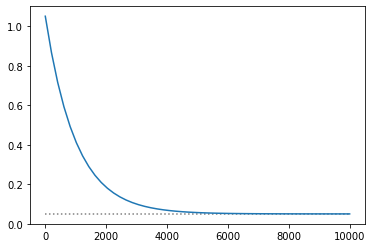

In [648]:
x = np.linspace(0,10_000)
base_epsilon = 0.05

epsilon = (np.exp(-x /1000)+base_epsilon)
plt.plot(x,epsilon)
plt.hlines(base_epsilon,0,10_000, color='grey',ls=':')

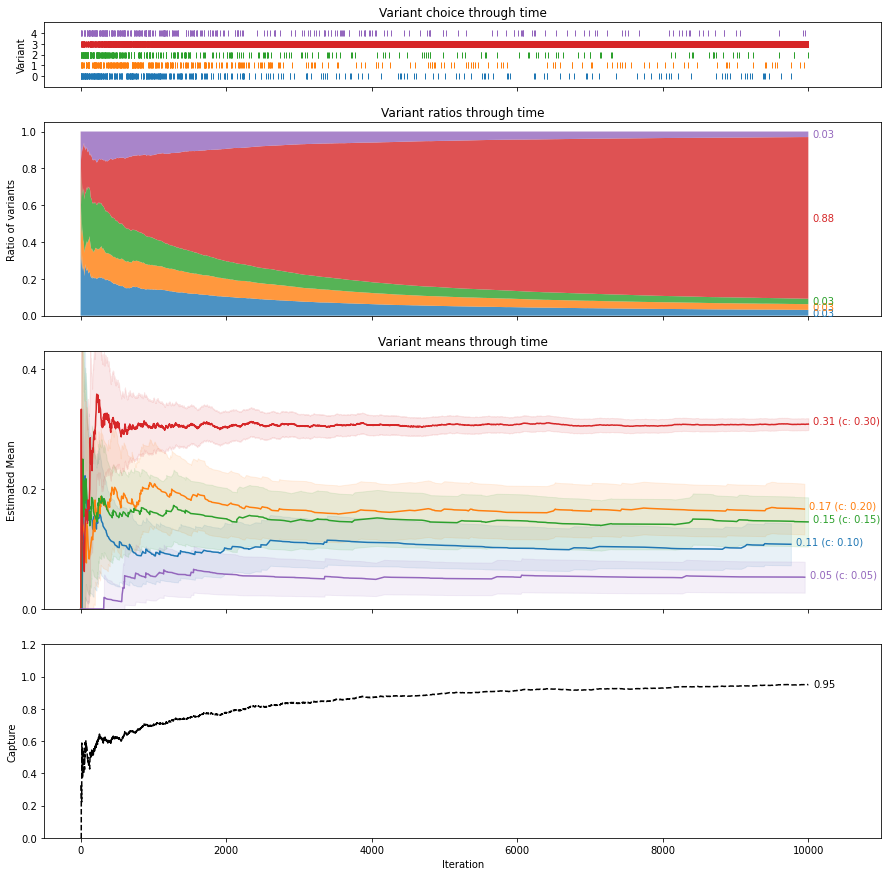

In [650]:
egreedy = simulation(sim_type='slow_greedy', epsilon = 0.05)
egreedy.run_simulation()
egreedy.plot_simulation_output()

# Closer proportions in the variants

In these examples, egreedy gets stuck on a sub-optimal variant, whereas the slow-greedy finds the correct one

Running simulation...Done
Plotting...Done


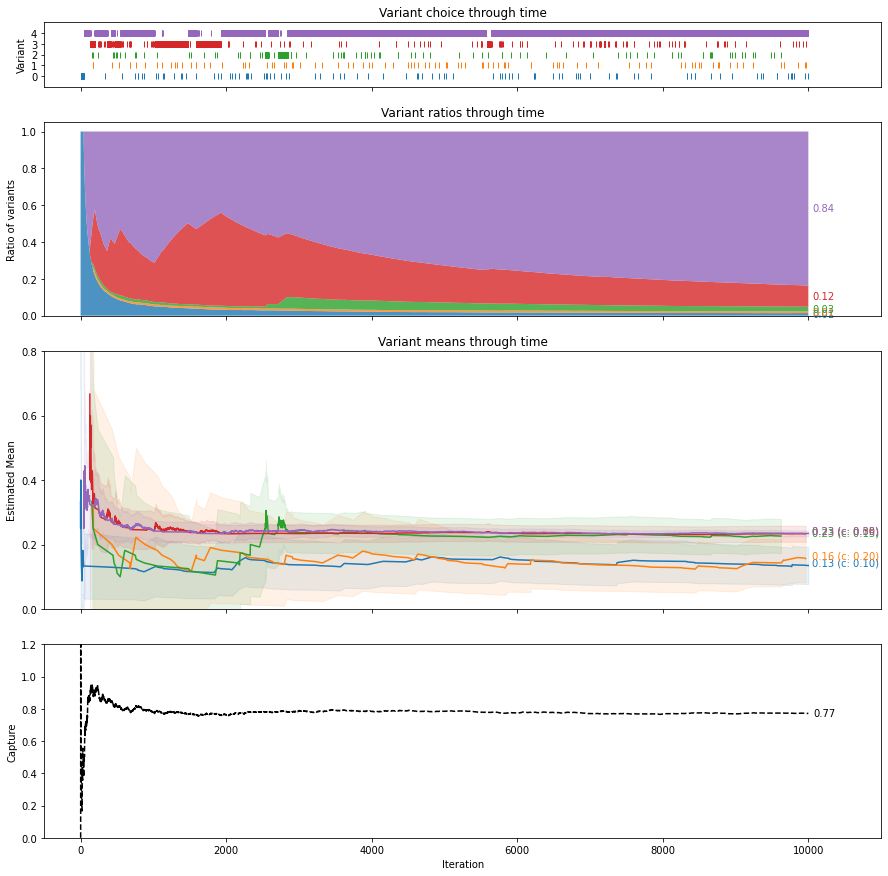

In [999]:
egreedy = simulation(iterations = 10_000, sim_type='egreedy', epsilon = 0.05, proportions = [0.2,0.21,0.22,0.23,0.24])
egreedy.run_simulation()
egreedy.plot_simulation_output()

Running simulation...Done
Plotting...Done


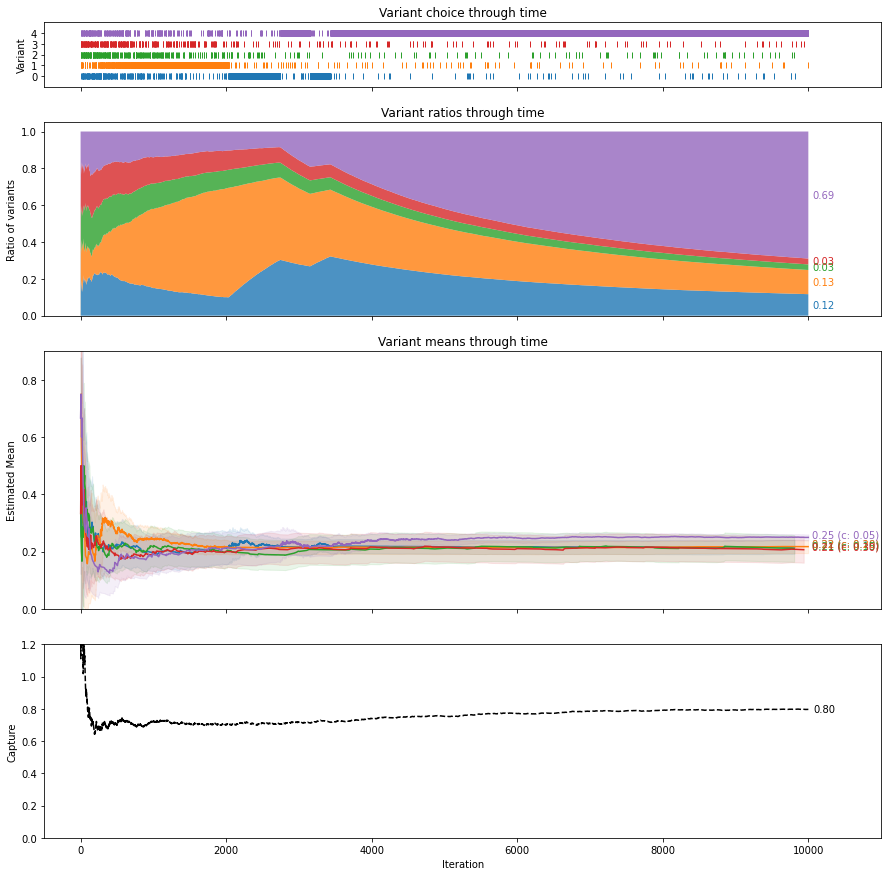

In [998]:
egreedy = simulation(iterations = 10_000, sim_type='slow_greedy', epsilon = 0.05, proportions = [0.2,0.21,0.22,0.23,0.24])
egreedy.run_simulation()
egreedy.plot_simulation_output()

Running simulation...Done
Plotting...Done


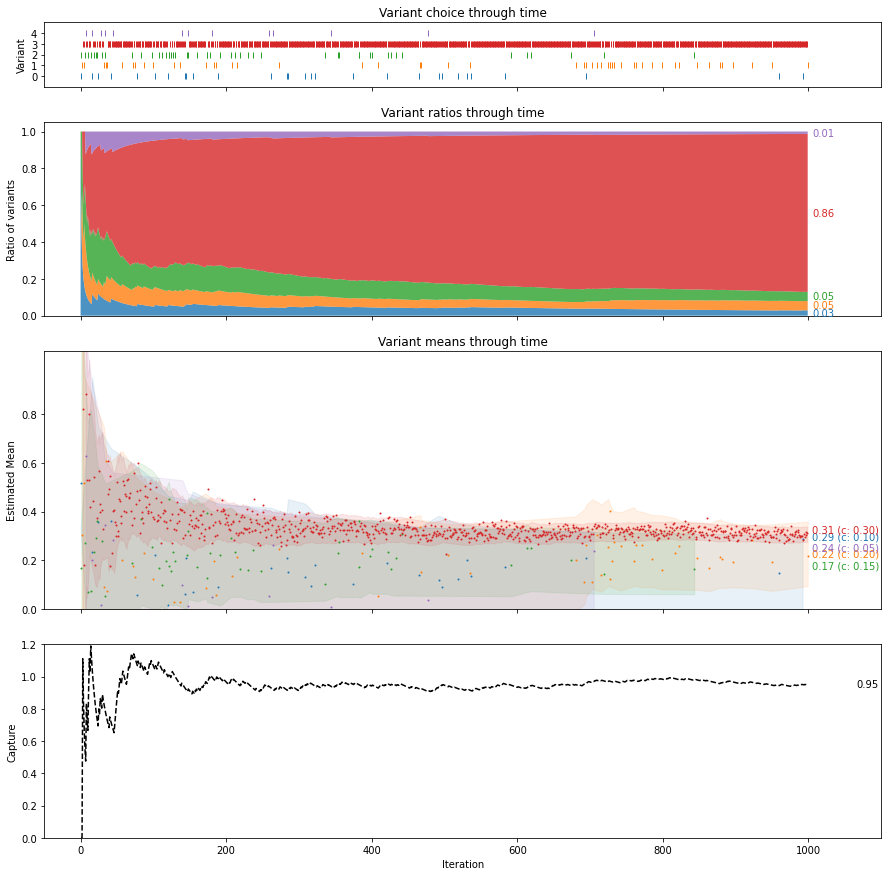

In [1005]:
thompson = simulation(sim_type='Thompson', iterations=1_000)
thompson.run_simulation()
thompson.plot_simulation_output()

In [724]:
np.random.beta(1,1)

0.9961227892167901

In [862]:
import plotly.express as px
#fig, ax = plt.subplots(1, 1)
a=1
b=1
x = np.linspace(stats.beta.ppf(0.01, a, b),
                stats.beta.ppf(0.99, a, b), 100)

results = [np.array([[0]*len(x),x,stats.beta.pdf(x, a, b)]).T]


for i in range(1,400):
    outcome = np.random.binomial(1,0.2)
    a += outcome
    b += 1-outcome
    if i<=40:
        results.append(np.array([[i]*len(x),x,stats.beta.pdf(x, a, b)]).T)   
    elif i%40==0:
        results.append(np.array([[i]*len(x),x,stats.beta.pdf(x, a, b)]).T)   

df = pd.DataFrame(np.concatenate(results), columns=['iteration','x','beta']).sort_values(['iteration','x'])

fig = px.line(df, x='x', y='beta', animation_frame='iteration',range_y=[0,10])

fig.show()


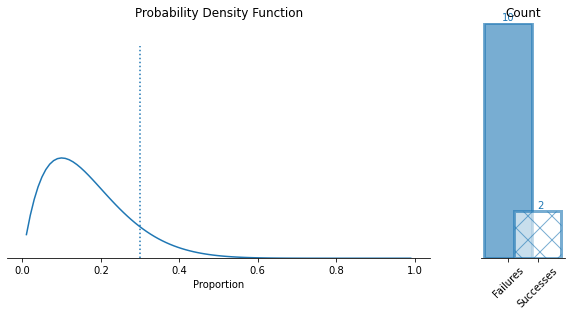

In [1064]:
import matplotlib.pyplot as plt
import ffmpeg
import os
from matplotlib import animation, rc, rcParams, gridspec
from IPython.display import HTML, Image
from matplotlib.animation import FFMpegWriter

# Set the FFmpeg path and defaults for display
plt.rcParams['animation.ffmpeg_path'] = '/Users/paulgstubley/Applications/ffmpeg/bin/ffmpeg'
proportion = 0.3

fig, ax = plt.subplots(figsize = (10,5))
gs = gridspec.GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[20, 1])  # Have thin bottom row to allow space for xlabel in gif (bug stops labels printing correctly otherwise)

ax = [plt.subplot(gs[0]),plt.subplot(gs[1])]

a=1
b=1
x = np.linspace(stats.beta.ppf(0.01, a, b),
                stats.beta.ppf(0.99, a, b), 100)


df = pd.DataFrame(egreedy.results, columns=['Iteration','Variant','Outcome','Variant_Count','Variant_Mean','Variant_Stddev','Successes','Failures'])
stacks = df.pivot(index='Iteration',columns='Variant',values=['Successes','Failures']).ffill().fillna(1)

a_list = stacks.Successes.astype(int)
b_list = stacks.Failures.astype(int)

line, = ax[0].plot(x,stats.beta.pdf(x, a, b));
ax[0].set_ylim([0,10])
ax[0].axvline(proportion,0,0.9, ls=':', color = 'C0')
ax[0].set_yticks([])
ax[0].set_title('Probability Density Function')
ax[0].set_xlabel('Proportion')

bar, = ax[1].bar(0, b, color='C0', alpha=0.6, edgecolor = 'C0', lw =3)
bar2, = ax[1].bar(0.5, a, facecolor='w', alpha=0.6, edgecolor='C0', lw =3, hatch='X')
ax[1].set_xticklabels(['','Failures','Successes'], rotation=45)
ax[1].set_title('Count')
ax[1].set_yticks([])
text =  ax[1].annotate(b,(0,b), va='bottom', ha='center', color = 'C0')
text2 = ax[1].annotate(a,(0.5,a), va='bottom', color = 'C0')

for spine in ['top','left','right']:
    ax[0].spines[spine].set_visible(False)
    ax[1].spines[spine].set_visible(False)

def init():

    return (line,)

def update(i, num_variants):
    global a
    global b
    for n in num_variants:

        line.set_data([x,stats.beta.pdf(x, a_list[i], b_list[i])])   
        bar.set_height(b_list[i])
        bar2.set_height(a_list[i])

        text.set_position((0, b_list[i]))
        text2.set_position((0.5, a_list[i]))
        text.set_text(b_list[i])
        text2.set_text(a_list[i])

    return (line,)

frames = 10
ax[1].set_ylim([0,frames])
anim = animation.FuncAnimation(fig, update, init_func=init,
                               frames=frames, interval=50,
                               blit=True, repeat=None)



HTML(anim.to_html5_video())
